In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/딥러닝2권/2권/07RNN_문장_생성

/content/drive/MyDrive/딥러닝2권/2권/07RNN_문장_생성


### 7.1 문장 생성 구현

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from models.rnnlm import Rnnlm
from models.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            # 확률로 가져옴
            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

In [5]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$'] # 예측에서 뺄 단어들
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n') # 개행문자로 대치
print(txt)

you beneficial cubic doug chose joke losses persuaded happens ticket conventional missed bondholders publications inquiries marking what respectable prohibit billings recommended deductible hoping trotter hard-disk temperatures high-grade right disk ability employs kitchen too earlier assault turner replacement instead achenbaum knight-ridder annuities ogden picked realistic voting communism roots restore auditors sets privatization quotron mich surprised actress machinists latest agnos ryder convert voluntary rain created elliott miners reportedly hanover upon quebecor more districts infringement approves extraordinary changing release confusing reflect arabs nfl fled va. besides engines collect temple conn. debates elements junior surprisingly lacking york infringed borrowers theirs brewing examiner recruit overtime


<ipython-input-3-d08c7187c6a1>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


### 모델 변경에 따른 결과값

In [4]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [17]:
LSTM = RnnlmGen() # 기본 LSTM
BetterLSTM = BetterRnnlmGen() # layer, dropout, 가중치 공유를 적용한 LSTM

LSTM.load_params('/content/drive/MyDrive/딥러닝2권/2권/models/Rnnlm.pkl')
BetterLSTM.load_params('/content/drive/MyDrive/딥러닝2권/2권/models/BetterRnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$'] # 예측에서 뺄 단어들
skip_ids = [word_to_id[w] for w in skip_words]

# LSTM
word_ids = LSTM.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n') # 개행문자로 대치
print('========= LSTM =========')
print(txt)
print()
# better LSTM
word_ids = BetterLSTM.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n') # 개행문자로 대치
print('========= better LSTM =========')
print(txt)

<ipython-input-3-d08c7187c6a1>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


========= LSTM =========
you futures aggressively public interior boost a series and chief executive officer.
 i think when mr. azoff says japan 's military older former former former former roman centers at seven days to yield in cross plants.
 mr. honecker chief executive officer and franchise mrs. roman offered less executive executive jones drug baltimore late london.
 too hardest one dozen tower many audience mr. honecker to have to serve a officer climate at least mr. krenz.
 mr. honecker ropes an giant roman team music president a director who we protect his newport system.
 we 've a new



<ipython-input-11-1148ffc1aaf2>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


========= better LSTM =========
you loser.
 brian j. l. whitten & marcus and gary w. trotter.
 the national cash adviser were being considered by david opponents of the investment banking division of retail banking and cineplex financial services.
 mr. roderick joined his chief treasury officer of the real estate group which would be part of the financial instrument of banking group.
 dick r. walker and president will be sold later in exchange for the board to extract the interest of a foreign-exchange company that will remove the company 's president.
 mr. gintel has n't raised his estimate of a


In [15]:
# the meaning of life is ~~

# LSTM
LSTM.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    LSTM.predict(x)

word_ids = LSTM.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n') # 개행문자로 대치
print('========= LSTM =========')
print(txt)
print()
# better LSTM
BetterLSTM.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    BetterLSTM.predict(x)


word_ids = BetterLSTM.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n') # 개행문자로 대치
print('========= better LSTM =========')
print(txt)

<ipython-input-3-d08c7187c6a1>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))
/content/drive/MyDrive/딥러닝2권/2권/07RNN_문장_생성/../common/functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


========= LSTM =========
the meaning of life is executive president he added.
 mr. reputation at was priced at year.
 tool direction mr. honecker was hurricane infrastructure for apple like unusual novel.
 in a price may cost of first actions to be used to times that are 1920s to make named.
 but to ringers to learn to expires often exclude trans deny high devastation to accused of roman and young boesky.
 so only one of its considering maryland galileo justify.
 last month and dinkins second beatrice add to cooperative red mr. honecker township chief executive important to close one ems.
 two



<ipython-input-11-1148ffc1aaf2>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


========= better LSTM =========
the meaning of life is likely.
 the iron business clear the picture to the european community through a crack of a problem says peter birmingham research director and the chamber of commerce 's recently enthusiastic barclays & phelps co.
 the slowdown said that up the japanese market is the americans who say widely were essential to the machines that beat the most extensive buildup of the business.
 according to mobil 's mercantile exchange mr. brady who is still to be thinking about the paper 's machine that used the u.s. through the ozone cycle he thinks sometimes answered that the price


성능은 안 좋음

## 7.3 seq2seq 구현

In [21]:
# dataset 확인
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984) # np.int로 되어있는 거 np.int32로 바꿔서 실행
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


### Encoder & Decoder

In [23]:
# Encoder
from common.time_layers import *

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None #  hidden state

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :] # 디코더로 맨 마지막 결과만 넘김

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh # 맨 마지막 결과만 가져옴

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [24]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True) # encoder에서 넘어온 hs를 받아야 하기에
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h) # encoder의 hidden state 받아오기 위해서

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h) # encoder hidden state

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten()) # 확률 상 가장 높은 것 가져오기
            sampled.append(int(sample_id))

        return sampled

### Seq2Seq

In [25]:
from common.base_model import BaseModel

class seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h) # decoder의 input으로는 맨 마지막 꺼 빼고 들어감
        loss = self.softmax.forward(score, decoder_ts) # decoder의 output에서 맨 처음 값은 안 나옴
        return loss

    def backward(self, dout = 1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size) # input: encoder의 hidden state, 시작 단어, size
        return sampled

### seq2seq 평가

In [9]:
import os

def eval_seq2seq(model, question, correct, id_to_char, verbos=False, is_reverse=False):
    correct = correct.flatten()

    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.22
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.98
| 에폭 1 |  반복 81 / 351 | 시간 6[s] | 손실 1.90
| 에폭 1 |  반복 101 / 351 | 시간 7[s] | 손실 1.86
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.78
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 14[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 14[s] | 손실 1.77
| 에폭 1 |  반복 261 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 18[s] | 손실 1.76
| 에폭 1 |  반복 301 / 351 | 시간 21[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 22[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 24[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---

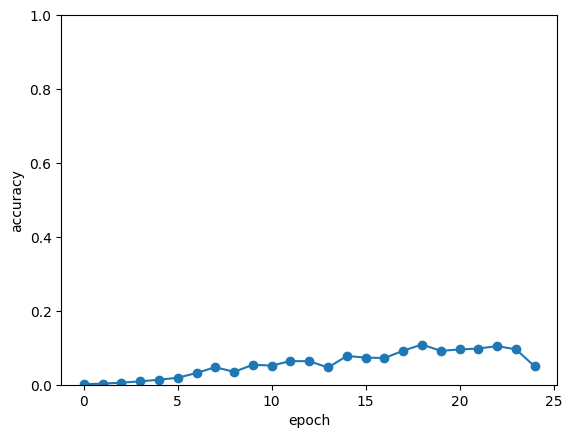

In [31]:
import matplotlib.pyplot as plt
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = False
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# hyper parameter
vocab_size = len(char_to_id)
wordvec_size = 10
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

## 7.4 seq2seq 개선

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.22
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.98
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 5[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 6[s] | 손실 1.85
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.85
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.84
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.82
| 에폭 1 |  반복 221 / 351 | 시간 10[s] | 손실 1.79
| 에폭 1 |  반복 241 / 351 | 시간 11[s] | 손실 1.79
| 에폭 1 |  반복 261 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 281 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 301 / 351 | 시간 14[s] | 손실 1.75
| 에폭 1 |  반복 321 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 341 / 351 | 시간 15[s] | 손실 1.75
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---


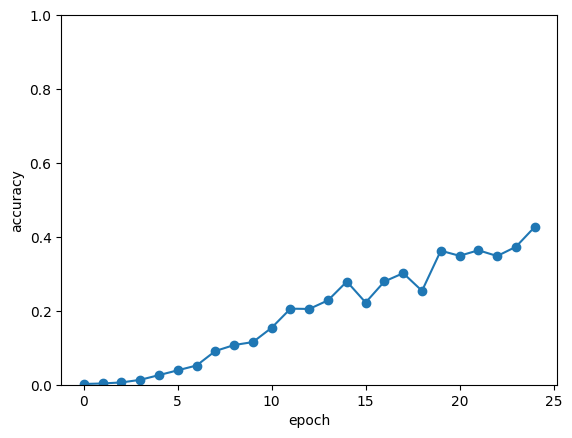

In [32]:
# 1. 입력 데이터 반전
# input과 output 관련 단어가 가까워져서, 기울기 전파가 더 잘 발생함.

# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# hyper parameter
vocab_size = len(char_to_id)
wordvec_size = 10
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

In [28]:
# 2. peeky
# 인코더의 hidden state 값을 모든 디코더의 모델에게 전달. concat 해서 활용

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # 임베딩 값 + hidden state
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # decoder의 hidden state + encoder hidden state
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True) # encoder에서 넘어온 hs를 받아야 하기에
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # 인코더 hidden state를 T개 layer에 적용
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [29]:
# peeky 적용
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H) # peeky 적용해서 변경
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.47
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.16
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.97
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.90
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.81
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.77
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 14[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 16[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 17[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 1006
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 100 
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---

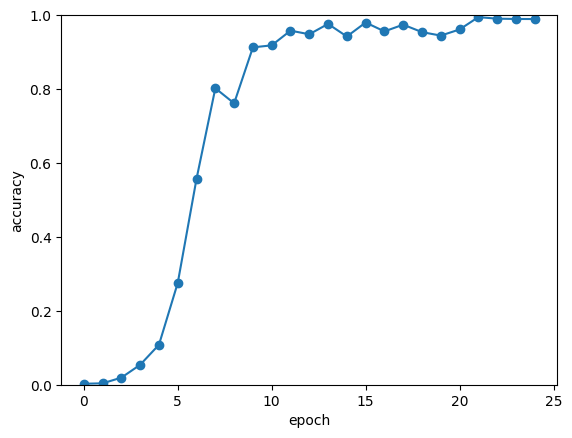

In [33]:
# peeky + reverse 학습

# dataset
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# hyper parameter
vocab_size = len(char_to_id)
wordvec_size = 10
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()